<a href="https://colab.research.google.com/github/hnioua/OCR-Text-Recognition-in-Challenging-Conditions/blob/main/NooteBook_OCR_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction du texte des images √† faible r√©solution (OCR)  


---

**R√©alis√© par :**  
- LAALIJI Zakariae  
- HNIOUA Abdessamad  
*√âtudiants en Master IAII, D√©partement Informatique*  
*Facult√© des Sciences et Techniques, Universit√© Cadi Ayyad, Marrakech, Maroc*

**Encadr√© par :**  
- Dr. Madame Laila Amir   
*Universit√© Cadi Ayyad*  
*Facult√© des Sciences et Techniques, Marrakech*  
*Master IAII ‚Äî D√©partement Informatique*


# Installation de biblioth√®que demander et importation des biblioth√®ques

In [1]:
!apt-get install unrar
!pip install keras-tuner
!pip install rarfile
!pip install imbalanced-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

In [4]:
# Librairies standards
import os  # Pour la gestion des fichiers et r√©pertoires
import random  # Pour les op√©rations al√©atoires (ex. s√©lection al√©atoire)
from collections import Counter, defaultdict  # Structures utiles pour les statistiques et les regroupements

# Gestion de donn√©es et visualisation
import numpy as np  # Pour les op√©rations num√©riques efficaces sur tableaux
import pandas as pd  # Pour la manipulation des donn√©es tabulaires (DataFrame)
import matplotlib.pyplot as plt  # Pour la visualisation de donn√©es
import seaborn as sns  # Pour les visualisations statistiques plus esth√©tiques

# Traitement d‚Äôimages
import cv2  # OpenCV pour la lecture, l‚Äô√©criture et le traitement d‚Äôimages
from PIL import Image  # Biblioth√®que PIL pour le traitement d‚Äôimages (alternative ou compl√©ment √† OpenCV)

# Machine Learning et pr√©traitement
from sklearn.model_selection import train_test_split  # Pour diviser le jeu de donn√©es en ensembles d'entra√Ænement/test
from sklearn.metrics import classification_report  # Pour g√©n√©rer un rapport d‚Äô√©valuation du mod√®le
from sklearn.preprocessing import LabelEncoder  # Pour convertir des √©tiquettes en valeurs num√©riques

# Gestion du d√©s√©quilibre de classes
from imblearn.over_sampling import SMOTE  # Technique d‚Äôoversampling pour √©quilibrer les classes minoritaires

# TensorFlow et Keras (mod√©lisation, entra√Ænement, callbacks)
import tensorflow as tf  # Biblioth√®que principale de deep learning
from tensorflow.keras.utils import to_categorical  # Conversion des labels en one-hot encoding
from tensorflow.keras.models import Sequential  # Mod√®le s√©quentiel simple
from tensorflow.keras.layers import (  # Couches de base pour cr√©er un r√©seau de neurones convolutionnel
    Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Flatten,
    GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam  # Optimiseur Adam
from tensorflow.keras.callbacks import (  # Callbacks utiles pour contr√¥ler l'entra√Ænement
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.applications import (  # R√©seaux de neurones pr√©-entra√Æn√©s
    EfficientNetB7, MobileNetV2, VGG19, DenseNet121
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # G√©n√©rateur d'images pour l'augmentation de donn√©es

# pour extraire des fichiers .rar si n√©cessaire
import rarfile  # Pour manipuler des fichiers compress√©s au format .rar


# 1) Pr√©paration du dataset

In [5]:
# Chemin vers le fichier RAR
rar_path = "Data.rar"  # Assure-toi que ce chemin est correct

# R√©pertoire de destination
extract_dir = "data_images"

# Extraire le contenu
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_dir)

In [6]:
with rarfile.RarFile(rar_path) as rf:
    for f in rf.infolist():
        try:
            rf.extract(f, extract_dir)
        except rarfile.BadRarFile as e:
            print(f"Erreur d'extraction pour {f.filename}: {e}")

### Augmentation de Donn√©es pour OCR sur Images √† Faible R√©solution

Ce chapitre pr√©sente les diff√©rentes techniques d‚Äôaugmentation de donn√©es appliqu√©es afin de simuler les d√©fauts courants dans les images √† faible r√©solution. L‚Äôobjectif est d‚Äôam√©liorer la robustesse du mod√®le OCR face √† des images bruit√©es, floues ou d√©grad√©es.


Pour am√©liorer un syst√®me OCR appliqu√© √† des images de **faible qualit√©**, on applique des **transformations artificielles** sur les images d'entra√Ænement. Cela renforce la **robustesse du mod√®le** face aux imperfections du monde r√©el.

### Transformations utilis√©es

| Transformation               | D√©faut simul√©                       | Objectif pour l'OCR                        |
|-----------------------------|-------------------------------------|-------------------------------------------|
| Bruit gaussien              | Bruit du capteur, compression       | Tol√©rance au bruit                         |
| Sel et poivre               | Pixels morts, artefacts             | Reconnaissance malgr√© des d√©fauts locaux   |
| Trous noirs                 | D√©t√©rioration, encre                | Reconna√Ætre des lettres incompl√®tes        |
| Variation de luminosit√©     | √âclairage in√©gal                    | Adaptabilit√© √† diff√©rentes expositions     |
| √âblouissement               | Reflets                             | Ignorer les zones surexpos√©es              |
| Compression JPEG            | Basse qualit√©                       | Lire les textes flous                      |
| Redimensionnement flou      | Flou optique                        | Reconna√Ætre des caract√®res mal nets        |
| Morphologie (√©rosion, etc.) | D√©formation du texte                | R√©sister aux variations structurelles      |
| Filtres de flou             | Mouvements, mise au point           | Robustesse au flou l√©ger                   |

Ces techniques d‚Äô**augmentation de donn√©es** simulent des d√©gradations r√©alistes. Elles permettent d‚Äô**entra√Æner un mod√®le OCR plus robuste**, capable de lire correctement du texte m√™me dans des **conditions d√©grad√©es ou r√©elles complexes**.


In [7]:
    # ---------------------
    # Fonctions de bruit
    # ---------------------

    def add_gaussian_noise(image, mean=0, sigma=20):
        # Ajoute un bruit gaussien √† l'image
        gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
        noisy = cv2.add(image, gauss)
        return noisy

    def add_salt_pepper_noise(image, amount=0.02):
        # Ajoute du bruit "sel et poivre"
        noisy = image.copy()
        num_pixels = int(amount * image.size)
        y_coords = np.random.randint(0, image.shape[0], num_pixels)
        x_coords = np.random.randint(0, image.shape[1], num_pixels)
        is_salt = np.random.choice([True, False], num_pixels)
        noisy[y_coords[is_salt], x_coords[is_salt]] = 255
        noisy[y_coords[~is_salt], x_coords[~is_salt]] = 0
        return noisy

    def add_holes(image, count=50, size=2):
        # Ajoute des trous noirs dans l'image
        img = image.copy()
        h, w = img.shape
        for _ in range(count):
            y = np.random.randint(0, h - size)
            x = np.random.randint(0, w - size)
            img[y:y+size, x:x+size] = 0
        return img

    def adjust_brightness(image, factor=1.2):
        # Ajuste la luminosit√© de l'image
        return np.clip(image * factor, 0, 255).astype(np.uint8)

    def add_glare(image, center=None, radius=30, intensity=150):
        # Ajoute un effet d'√©blouissement circulaire
        glare = np.zeros_like(image)
        if center is None:
            center = (image.shape[1]//2, image.shape[0]//2)
        cv2.circle(glare, center, radius, (intensity,), -1)
        glare = cv2.GaussianBlur(glare, (0, 0), radius/2)
        return np.clip(image + glare, 0, 255).astype(np.uint8)

    def reduce_quality(image, quality=30):
        # R√©duit la qualit√© JPEG de l'image
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', image, encode_param)
        decimg = cv2.imdecode(encimg, 0)
        return decimg

    def downscale_then_upscale(image, scale=0.5):
        # R√©duit et r√©agrandit l'image pour flouter l√©g√®rement
        h, w = image.shape
        small = cv2.resize(image, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        return cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)

    # ---------------------
    # Fonctions morphologiques
    # ---------------------

    def apply_morphology(image, operation='erode', kernel_size=3):
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        if operation == 'erode':
            return cv2.erode(image, kernel, iterations=1)
        elif operation == 'dilate':
            return cv2.dilate(image, kernel, iterations=1)
        elif operation == 'open':
            return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        elif operation == 'close':
            return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        return image

In [8]:
# Charger une image en niveaux de gris depuis un chemin donn√©
img_path = 'data_images/data/E/44366.png'  # √Ä adapter selon votre image

# Cr√©e un r√©pertoire de sortie s'il n'existe pas
os.makedirs("output", exist_ok=True)

# Tente de charger l'image
print(f"Tentative de chargement de l'image : {img_path}")
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# V√©rifie si l'image a √©t√© charg√©e avec succ√®s
if img is None:
    print(f"Erreur : impossible de charger l'image depuis le chemin : {img_path}")
    print("Veuillez v√©rifier le chemin du fichier et vous assurer que l'image existe et n'est pas corrompue.")
else:
    print(f"Image charg√©e avec succ√®s. Dimensions : {img.shape}")


Tentative de chargement de l'image : data_images/data/E/44366.png
Image charg√©e avec succ√®s. Dimensions : (36, 27)


In [9]:
    print("Application des diff√©rentes transformations d'image...")
     # ---------------------
    # Appliquer toutes les transformations
    # ---------------------
    transformations = {
        "original": img,
        "gaussian_noise": add_gaussian_noise(img, sigma=10),
        "salt_pepper": add_salt_pepper_noise(img, amount=0.005),
        "holes": add_holes(img, count=10, size=2),
        "bright": adjust_brightness(img, 1.5),
        "dark": adjust_brightness(img, 0.5),
        "glare": add_glare(img, radius=20, intensity=80),
        "jpeg_quality": reduce_quality(img, quality=60),
        "downscale_upscale": downscale_then_upscale(img, scale=0.8),
        "eroded": apply_morphology(img, 'erode'),
        "dilated": apply_morphology(img, 'dilate'),
        "opened": apply_morphology(img, 'open'),
        "closed": apply_morphology(img, 'close'),
        "blur_mean": cv2.blur(img, (5, 5)),
        "blur_gaussian": cv2.GaussianBlur(img, (5, 5), 0),
        "blur_median": cv2.medianBlur(img, 5),
    }

    # Sauvegarde des images transform√©es
    for name, transformed in transformations.items():
        out_path = f"output/{name}.png"
        cv2.imwrite(out_path, transformed)
        print(f"Image '{name}' enregistr√©e dans {out_path}")

Application des diff√©rentes transformations d'image...
Image 'original' enregistr√©e dans output/original.png
Image 'gaussian_noise' enregistr√©e dans output/gaussian_noise.png
Image 'salt_pepper' enregistr√©e dans output/salt_pepper.png
Image 'holes' enregistr√©e dans output/holes.png
Image 'bright' enregistr√©e dans output/bright.png
Image 'dark' enregistr√©e dans output/dark.png
Image 'glare' enregistr√©e dans output/glare.png
Image 'jpeg_quality' enregistr√©e dans output/jpeg_quality.png
Image 'downscale_upscale' enregistr√©e dans output/downscale_upscale.png
Image 'eroded' enregistr√©e dans output/eroded.png
Image 'dilated' enregistr√©e dans output/dilated.png
Image 'opened' enregistr√©e dans output/opened.png
Image 'closed' enregistr√©e dans output/closed.png
Image 'blur_mean' enregistr√©e dans output/blur_mean.png
Image 'blur_gaussian' enregistr√©e dans output/blur_gaussian.png
Image 'blur_median' enregistr√©e dans output/blur_median.png


Affichage des images transform√©es :


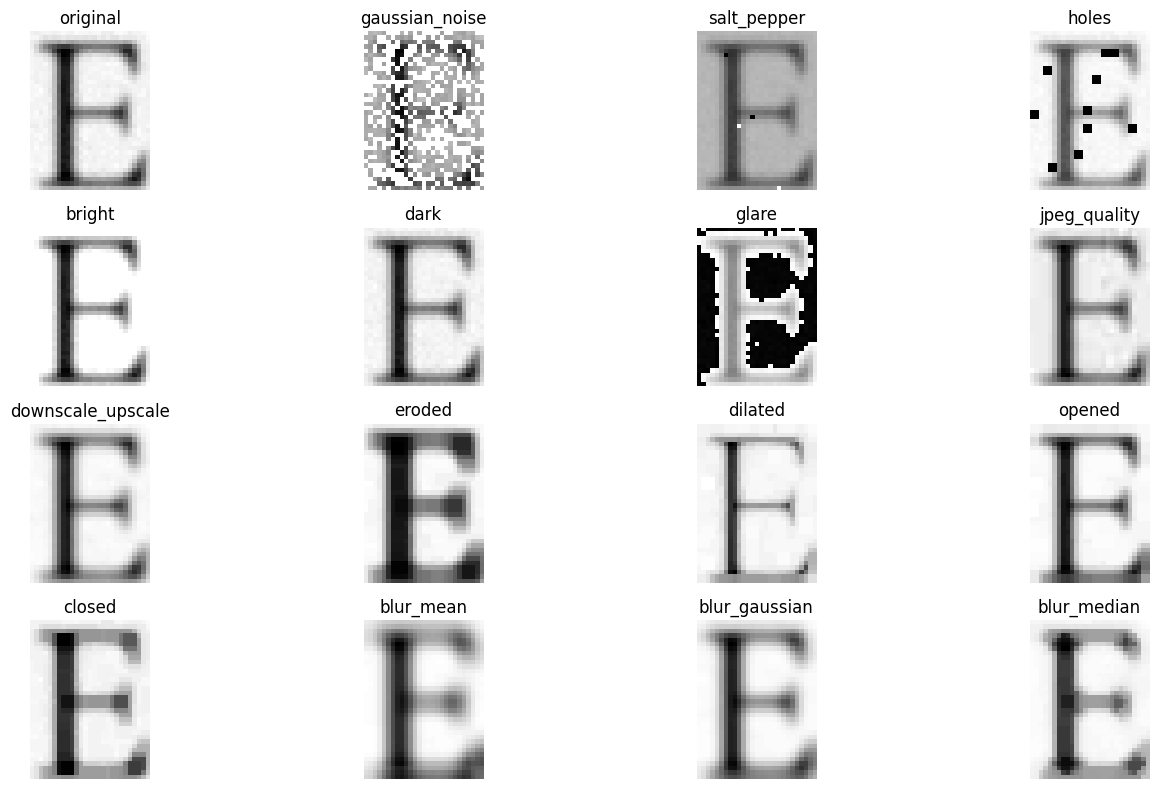

In [ ]:
   # Affiche toutes les images transform√©es dans une grille matplotlib
print("Affichage des images transform√©es :")
plt.figure(figsize=(15, 8))
for i, (name, transformed) in enumerate(transformations.items()):
    plt.subplot(4, 4, i+1)
    plt.imshow(transformed, cmap='gray')
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

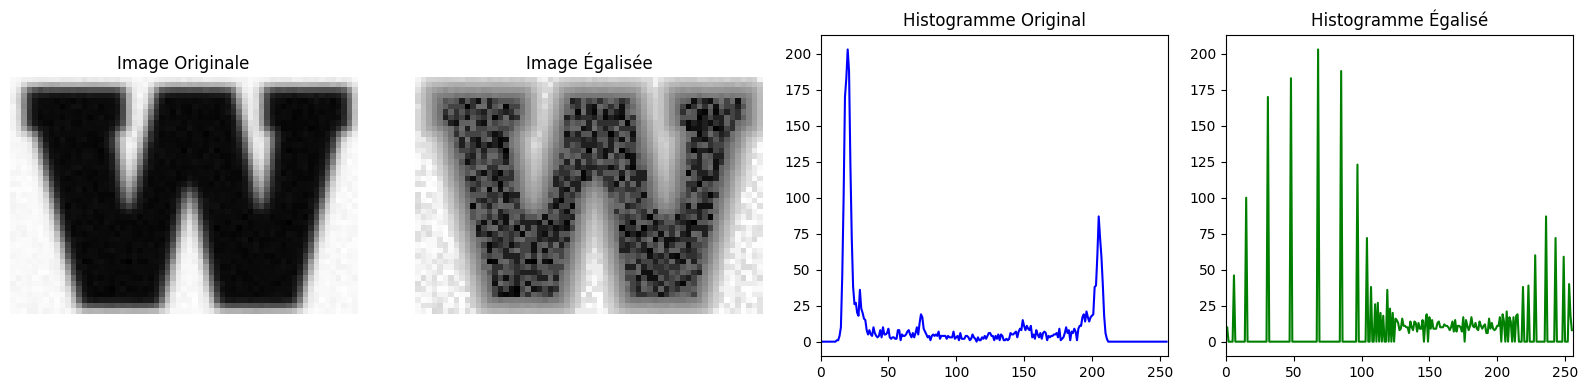

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
img_path = "data_images/data/W/41792.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Appliquer l'√©galisation d'histogramme
equalized = cv2.equalizeHist(img)

# Calculer les histogrammes
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_equalized = cv2.calcHist([equalized], [0], None, [256], [0, 256])

# Affichage
plt.figure(figsize=(16, 4))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Image Originale")
plt.axis('off')

# Image √©galis√©e
plt.subplot(1, 4, 2)
plt.imshow(equalized, cmap='gray')
plt.title("Image √âgalis√©e")
plt.axis('off')

# Histogramme original
plt.subplot(1, 4, 3)
plt.plot(hist_original, color='blue')
plt.title("Histogramme Original")
plt.xlim([0, 256])

# Histogramme √©galis√©
plt.subplot(1, 4, 4)
plt.plot(hist_equalized, color='green')
plt.title("Histogramme √âgalis√©")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()


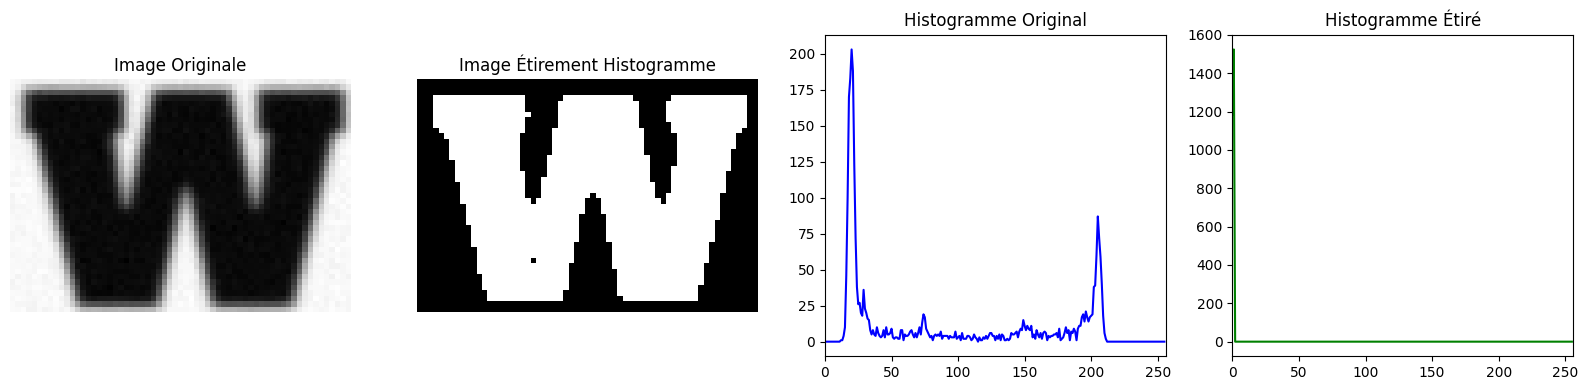

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
img_path = "data_images/data/W/41792.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# √âtirement d'histogramme
min_val = np.min(img)
max_val = np.max(img)
stretched = ((img - min_val) * 255 / (max_val - min_val)).astype(np.uint8)

# Calcul des histogrammes
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_stretched = cv2.calcHist([stretched], [0], None, [256], [0, 256])

# Affichage
plt.figure(figsize=(16, 4))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Image Originale")
plt.axis('off')

# Image √©tir√©e
plt.subplot(1, 4, 2)
plt.imshow(stretched, cmap='gray')
plt.title("Image √âtirement Histogramme")
plt.axis('off')

# Histogramme original
plt.subplot(1, 4, 3)
plt.plot(hist_original, color='blue')
plt.title("Histogramme Original")
plt.xlim([0, 256])

# Histogramme √©tir√©
plt.subplot(1, 4, 4)
plt.plot(hist_stretched, color='green')
plt.title("Histogramme √âtir√©")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()


###Cr√©ation d'un DataFrame des images et de leurs √©tiquettes

Parcourt les dossiers d‚Äôimages class√©s par √©tiquette (lettres/chiffres) et construit un DataFrame contenant le chemin de chaque image ainsi que son label associ√©.


In [ ]:
# Dossier racine des images extraites
base_dir = "data_images/data"

# Liste pour stocker les donn√©es
data = []

# Parcours tous les sous-dossiers (A, B, C, ..., 0, 1, 2, ...)
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        # Parcours toutes les images dans ce dossier
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                data.append({'image': image_path, 'label': folder_name})

# Cr√©ation du DataFrame
df = pd.DataFrame(data)

# Affichage des premi√®res lignes
df.head()

image label
0  data_images/data/E/44366.png     E
1  data_images/data/E/41738.png     E
2  data_images/data/E/43754.png     E
3  data_images/data/E/42062.png     E
4  data_images/data/E/43718.png     E

## Fonctions de transformation

In [ ]:
# ---------------------
# Fonctions de transformation
# ---------------------
def add_gaussian_noise(image, mean=0, sigma=20):
    gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    return cv2.add(image, gauss)

def add_salt_pepper_noise(image, amount=0.02):
    noisy = image.copy()
    num_pixels = int(amount * image.size)
    y_coords = np.random.randint(0, image.shape[0], num_pixels)
    x_coords = np.random.randint(0, image.shape[1], num_pixels)
    is_salt = np.random.choice([True, False], num_pixels)
    noisy[y_coords[is_salt], x_coords[is_salt]] = 255
    noisy[y_coords[~is_salt], x_coords[~is_salt]] = 0
    return noisy

def add_holes(image, count=50, size=2):
    img = image.copy()
    h, w = img.shape
    for _ in range(count):
        y = np.random.randint(0, h - size)
        x = np.random.randint(0, w - size)
        img[y:y+size, x:x+size] = 0
    return img

def adjust_brightness(image, factor=1.2):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def add_glare(image, center=None, radius=30, intensity=150):
    glare = np.zeros_like(image)
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.circle(glare, center, radius, (intensity,), -1)
    glare = cv2.GaussianBlur(glare, (0, 0), radius / 2)
    return np.clip(image + glare, 0, 255).astype(np.uint8)

def reduce_quality(image, quality=30):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encimg, 0)

def downscale_then_upscale(image, scale=0.5):
    h, w = image.shape
    small = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    return cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)

def apply_morphology(image, operation='erode', kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    if operation == 'erode':
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'dilate':
        return cv2.dilate(image, kernel, iterations=1)
    elif operation == 'open':
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image

# ---------------------
# Dataset
# ---------------------
base_dir = "data_images/data"
transformations = {
    "gaussian": lambda img: add_gaussian_noise(img, sigma=10),
    "saltpepper": lambda img: add_salt_pepper_noise(img, amount=0.005),
    "holes": lambda img: add_holes(img, count=10, size=2),
    "bright": lambda img: adjust_brightness(img, 1.5),
    "dark": lambda img: adjust_brightness(img, 0.5),
    "glare": lambda img: add_glare(img, radius=20, intensity=80),
    "jpeg": lambda img: reduce_quality(img, quality=60),
    "resize": lambda img: downscale_then_upscale(img, scale=0.8),
    "erode": lambda img: apply_morphology(img, 'erode'),
    "dilate": lambda img: apply_morphology(img, 'dilate'),
    "open": lambda img: apply_morphology(img, 'open'),
    "close": lambda img: apply_morphology(img, 'close'),
    "blur_mean": lambda img: cv2.blur(img, (5, 5)),
    "blur_gaussian": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    "blur_median": lambda img: cv2.medianBlur(img, 5),
}

count = 0

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Sauvegarder les transformations dans le m√™me dossier
            name_base, ext = os.path.splitext(filename)
            for suffix, func in transformations.items():
                transformed = func(img)
                new_filename = f"{name_base}_{suffix}{ext}"
                cv2.imwrite(os.path.join(folder_path, new_filename), transformed)
                count += 1

print(f"Termin√© : {count} images transform√©es et sauvegard√©es.")


Termin√© : 48615 images transform√©es et sauvegard√©es.


In [ ]:
# Dictionnaire pour stocker le comptage par label
label_counts = defaultdict(int)

# Extensions d'images √† consid√©rer
valid_exts = ('.png', '.jpg', '.jpeg')

# Parcours des dossiers pour compter les images
for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    # Compter les fichiers image dans ce dossier
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    label_counts[label_folder] = len(image_files)

In [ ]:
# Assume base_dir is defined as in your code
base_dir = "data_images/data"

# Assume label_counts is populated as in your code
label_counts = defaultdict(int)
valid_exts = ('.png', '.jpg', '.jpeg')

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    label_counts[label_folder] = len(image_files)

# Convert the defaultdict to a pandas Series
label_series = pd.Series(label_counts)

# Sort the series by index (label) for consistent plotting
label_series = label_series.sort_index()

###  Distribution des labels et √©quilibrage des donn√©es

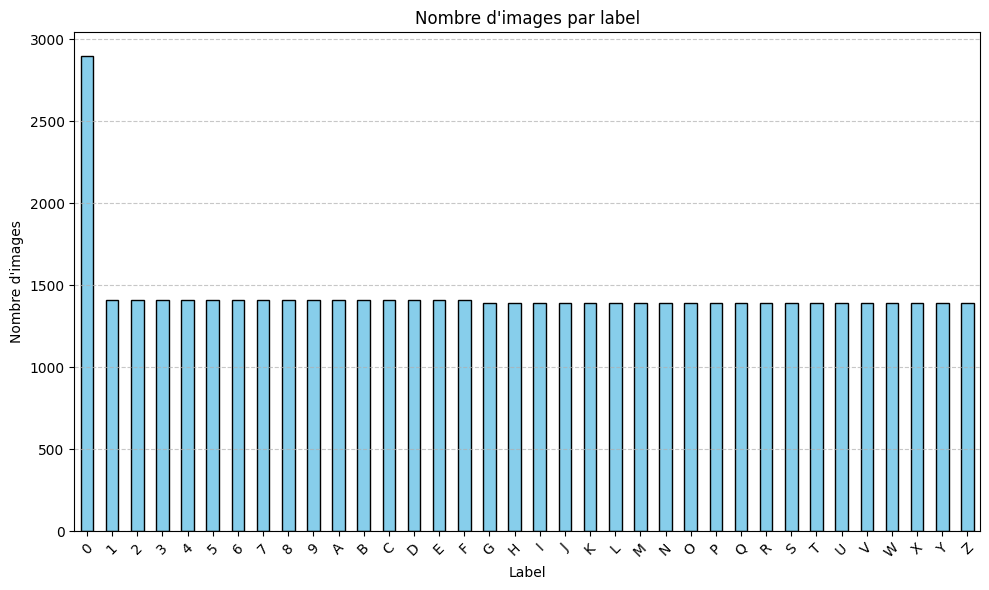

In [ ]:
# Graphe en barres
plt.figure(figsize=(10, 6))
label_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'images par label")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Le graphique montre un d√©s√©quilibre clair : la classe **'0'** contient beaucoup plus d'images (2900) que les autres (1400). Ce d√©s√©quilibre peut fausser l'entra√Ænement du mod√®le.

Pour corriger cela, on peut utiliser :

- **Oversampling** : augmenter artificiellement les donn√©es des classes minoritaires (ex. : duplication, SMOTE).
- **Undersampling** : r√©duire les donn√©es de la classe majoritaire.

 **But** : √©quilibrer les classes pour am√©liorer la performance et la justesse du mod√®le sur toutes les cat√©gories.



###   Conversion d‚Äôune image en vecteur num√©rique

Chaque image de notre jeu de donn√©es est :
- en **niveaux de gris** (grayscale) ‚Üí chaque pixel est un entier compris entre 0 (noir) et 255 (blanc),
- **redimensionn√©e** √† une taille uniforme de `32 x 32` pixels.

Cela signifie que chaque image contient exactement :

> **32 √ó 32 = 1024 pixels**

Ces pixels sont ensuite **aplaties** (transform√©es en un vecteur 1D), par exemple :


### Fonction `flatten()` en NumPy

La m√©thode `.flatten()` permet de **transformer un tableau multidimensionnel en un vecteur unidimensionnel**.

---

#### Principe

- Si vous avez une image repr√©sent√©e par une matrice 2D, par exemple de taille `(32, 32)` pixels, chaque pixel √©tant un √©l√©ment de cette matrice.
- La fonction `flatten()` convertit cette matrice 2D en un vecteur 1D contenant tous les pixels, rang√©s **en parcourant la matrice ligne par ligne**.

---

#### Exemple

Soit une matrice 2x2 :

```python
import numpy as np

matrice = np.array([[1, 2],
                    [3, 4]])
vecteur = matrice.flatten()
print(vecteur)  # Affiche : [1 2 3 4]


In [ ]:
# Dossier des images par classe
base_dir = "data_images/data"
TARGET_SIZE = (32, 32)

data, labels = [], []

print("Chargement et pr√©traitement des images...")

# Parcours des sous-dossiers de classes
for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if not os.path.isdir(folder_path):
        continue

    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, TARGET_SIZE)
                data.append(img.flatten())
                labels.append(label)

# Conversion en tableaux NumPy
X = np.array(data)
y = np.array(labels)

print("Distribution des classes avant SMOTE :", Counter(y))

Chargement et pr√©traitement des images...
Distribution des classes avant SMOTE : Counter({np.str_('0'): 2896, np.str_('E'): 1408, np.str_('B'): 1408, np.str_('6'): 1408, np.str_('3'): 1408, np.str_('4'): 1408, np.str_('5'): 1408, np.str_('C'): 1408, np.str_('2'): 1408, np.str_('1'): 1408, np.str_('8'): 1408, np.str_('9'): 1408, np.str_('A'): 1408, np.str_('F'): 1408, np.str_('7'): 1408, np.str_('D'): 1408, np.str_('O'): 1392, np.str_('N'): 1392, np.str_('J'): 1392, np.str_('V'): 1392, np.str_('I'): 1392, np.str_('U'): 1392, np.str_('Y'): 1392, np.str_('P'): 1392, np.str_('G'): 1392, np.str_('R'): 1392, np.str_('W'): 1392, np.str_('H'): 1392, np.str_('L'): 1392, np.str_('Z'): 1392, np.str_('M'): 1392, np.str_('S'): 1392, np.str_('X'): 1392, np.str_('T'): 1392, np.str_('Q'): 1392, np.str_('K'): 1392})


### Pourquoi utiliser SMOTE (Oversampling) ?

L'ensemble de donn√©es initial contient seulement 48 615 images, ce qui peut √™tre insuffisant pour entra√Æner un mod√®le OCR performant, surtout avec des classes d√©s√©quilibr√©es.  

Pour augmenter la taille des donn√©es tout en √©quilibrant la distribution des classes, nous utilisons **SMOTE (Synthetic Minority Over-sampling Technique)**. Cette m√©thode g√©n√®re des exemples synth√©tiques des classes minoritaires en interpolant entre les exemples existants, ce qui am√©liore la diversit√© et la repr√©sentativit√© des donn√©es.

Nous pr√©f√©rons **SMOTE (oversampling)** √† une m√©thode d‚Äô**undersampling** qui consisterait √† r√©duire les classes majoritaires. En effet, l‚Äôundersampling peut entra√Æner la perte d‚Äôexemples pertinents et r√©duire la richesse des donn√©es, ce qui n‚Äôest pas souhaitable quand la quantit√© totale d‚Äôimages est d√©j√† limit√©e.


In [ ]:
# Application de SMOTE pour √©quilibrer les classes
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Distribution des classes apr√®s SMOTE :", Counter(y_resampled))

Distribution des classes apr√®s SMOTE : Counter({np.str_('E'): 2896, np.str_('O'): 2896, np.str_('N'): 2896, np.str_('J'): 2896, np.str_('V'): 2896, np.str_('B'): 2896, np.str_('6'): 2896, np.str_('3'): 2896, np.str_('4'): 2896, np.str_('I'): 2896, np.str_('5'): 2896, np.str_('U'): 2896, np.str_('C'): 2896, np.str_('Y'): 2896, np.str_('P'): 2896, np.str_('0'): 2896, np.str_('G'): 2896, np.str_('R'): 2896, np.str_('2'): 2896, np.str_('1'): 2896, np.str_('W'): 2896, np.str_('H'): 2896, np.str_('L'): 2896, np.str_('8'): 2896, np.str_('Z'): 2896, np.str_('9'): 2896, np.str_('M'): 2896, np.str_('A'): 2896, np.str_('F'): 2896, np.str_('S'): 2896, np.str_('7'): 2896, np.str_('X'): 2896, np.str_('D'): 2896, np.str_('T'): 2896, np.str_('Q'): 2896, np.str_('K'): 2896})


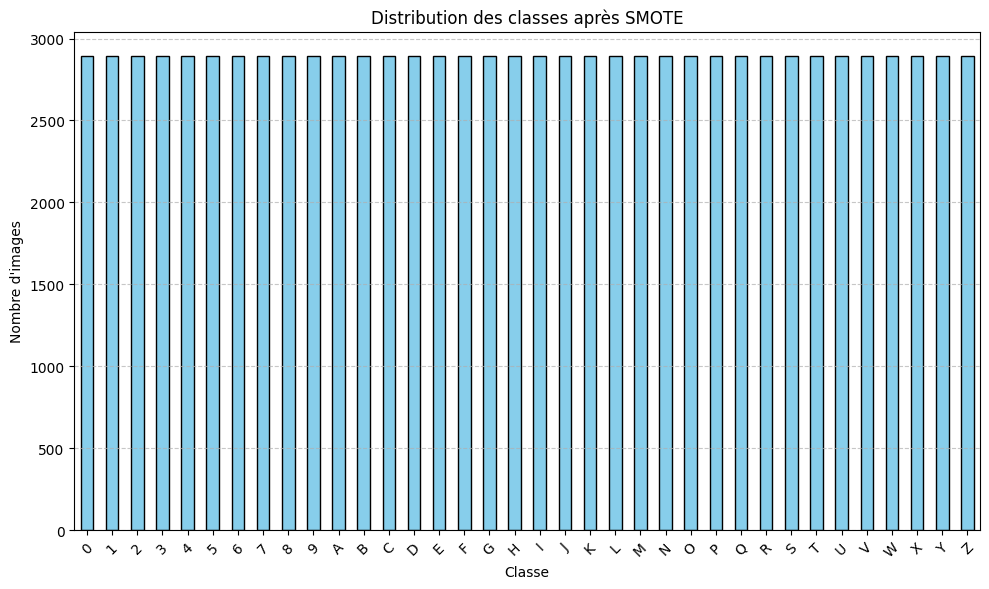

In [ ]:
# Visualisation de la distribution apr√®s SMOTE
label_counts = Counter(y_resampled)
label_series = pd.Series(label_counts).sort_index()

plt.figure(figsize=(10, 6))
label_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des classes apr√®s SMOTE")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Affichage d'exemples d'images par label :


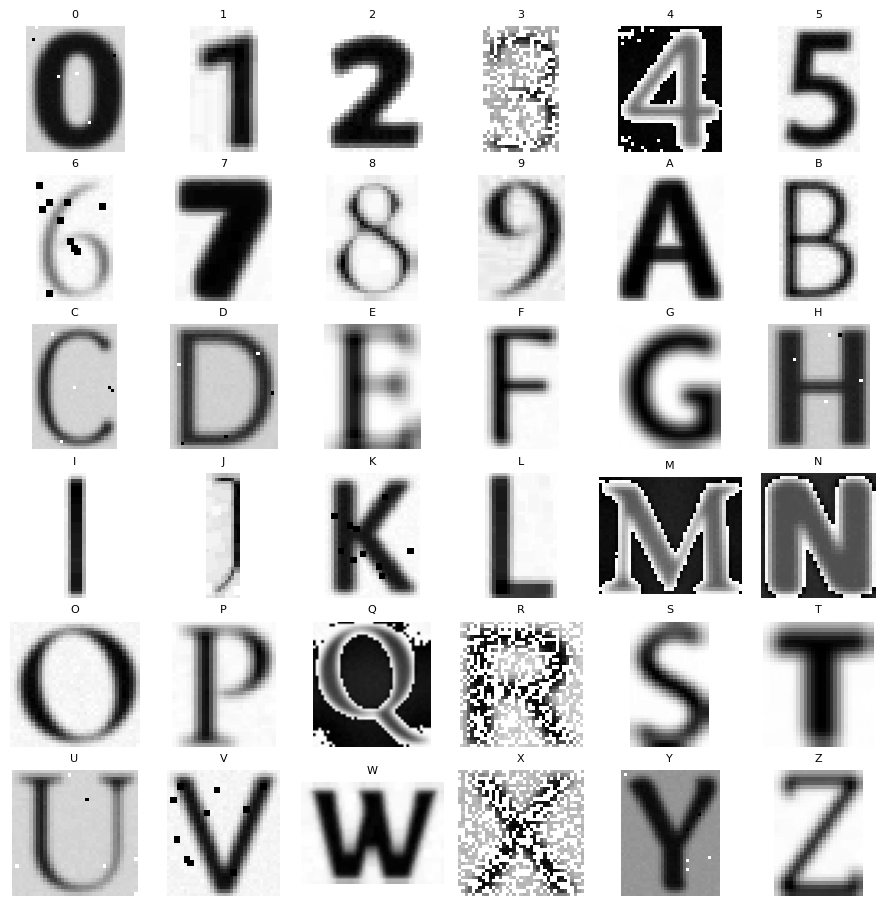

In [ ]:
NUM_EXAMPLES_PER_LABEL = 1

print("\nAffichage d'exemples d'images par label :")

label_folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])
num_labels = len(label_folders)

cols = int(np.ceil(np.sqrt(num_labels)))
rows = int(np.ceil(num_labels / cols))

# Taille de figure r√©duite
plt.figure(figsize=(cols * 1.5, rows * 1.5))

for i, label_folder in enumerate(label_folders):
    folder_path = os.path.join(base_dir, label_folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        selected_images = random.sample(image_files, min(NUM_EXAMPLES_PER_LABEL, len(image_files)))

        for filename in selected_images:
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                plt.subplot(rows, cols, i + 1)
                plt.imshow(img, cmap='gray')
                plt.title(label_folder, fontsize=8)  # Titre plus petit
                plt.axis('off')

plt.tight_layout(pad=0.5)  # Moins d'espacement
plt.show()


### Division du jeu de donn√©es √©quilibr√© apr√®s SMOTE

Apr√®s avoir appliqu√© **SMOTE** pour √©quilibrer les classes, nous proc√©dons √† la s√©paration du jeu de donn√©es en deux sous-ensembles :

- **80 % pour l'entra√Ænement** (`X_train`, `y_train`)
- **20 % pour le test** (`X_test`, `y_test`)

La m√©thode `train_test_split` est utilis√©e avec l‚Äôoption `stratify=y_resampled` afin de conserver une distribution √©quilibr√©e des classes dans les deux sous-ensembles.

Ensuite, les tableaux NumPy sont convertis en `DataFrame` (pour `X`) et en `Series` (pour `y`) pour une manipulation plus ais√©e avec **pandas**.

Enfin, chaque jeu (`X` et `y`) est concat√©n√© en un seul `DataFrame` :
- `training_df` contient les exemples d‚Äôentra√Ænement avec leurs √©tiquettes.
- `testing_df` contient les exemples de test.



In [ ]:
#  √âtape 1 : S√©parer les donn√©es √©quilibr√©es en ensembles d'entra√Ænement et de test
# On utilise 80 % des donn√©es pour l'entra√Ænement et 20 % pour le test
# L'argument stratify permet de conserver la m√™me proportion de chaque classe dans les deux ensembles
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Affichage des dimensions des jeux de donn√©es
print(f"Forme de X_train : {X_train.shape}, Forme de y_train : {y_train.shape}")
print(f"Forme de X_test : {X_test.shape}, Forme de y_test : {y_test.shape}")

# √âtape 2 : Conversion des tableaux NumPy en DataFrame (X) et Series (y)
X_train_df = pd.DataFrame(X_train)              # Donn√©es d'entra√Ænement
y_train_series = pd.Series(y_train, name='label')  # √âtiquettes d'entra√Ænement

X_test_df = pd.DataFrame(X_test)                # Donn√©es de test
y_test_series = pd.Series(y_test, name='label')    # √âtiquettes de test

Forme de X_train : (83404, 1024), Forme de y_train : (83404,)
Forme de X_test : (20852, 1024), Forme de y_test : (20852,)


In [ ]:
#  √âtape 3 : Fusion des donn√©es X et des labels y pour constituer un seul DataFrame
# ignore_index=True permet de r√©initialiser l'index pour √©viter les duplications
training_df = pd.concat([X_train_df, y_train_series], axis=1, ignore_index=True)
testing_df = pd.concat([X_test_df, y_test_series], axis=1, ignore_index=True)

# Affichage d‚Äôun aper√ßu des deux DataFrames g√©n√©r√©s
print("\nCr√©ation des DataFrames training_df et testing_df :")
print("Aper√ßu de training_df :")
training_df.head()


Cr√©ation des DataFrames training_df et testing_df :
Aper√ßu de training_df :


0     1     2     3     4     5     6     7     8     9     ...  1015  \
0   178   178   178   171   157   140   135   131   131   131  ...    65   
1   217   217   217   217   216   215   214   213   212   210  ...   169   
2    94    94    94    94    93    93    94    95    94    95  ...    67   
3   220   220   221   221   219   216   211   201   190   178  ...   185   
4   198   198   191   191   186   184   184   183   185   186  ...   151   

   1016  1017  1018  1019  1020  1021  1022  1023  1024  
0    65    64    64    64    65    74    98    98     Z  
1   169   169   170   175   182   195   203   208     2  
2    68    66    66    67    71    74    82    90     M  
3   195   203   210   215   218   219   220   221     5  
4   150   148   148   148   158   171   185   185     E  

[5 rows x 1025 columns]


Nombre d'images par label dans l'ensemble d'entra√Ænement (y_train) :


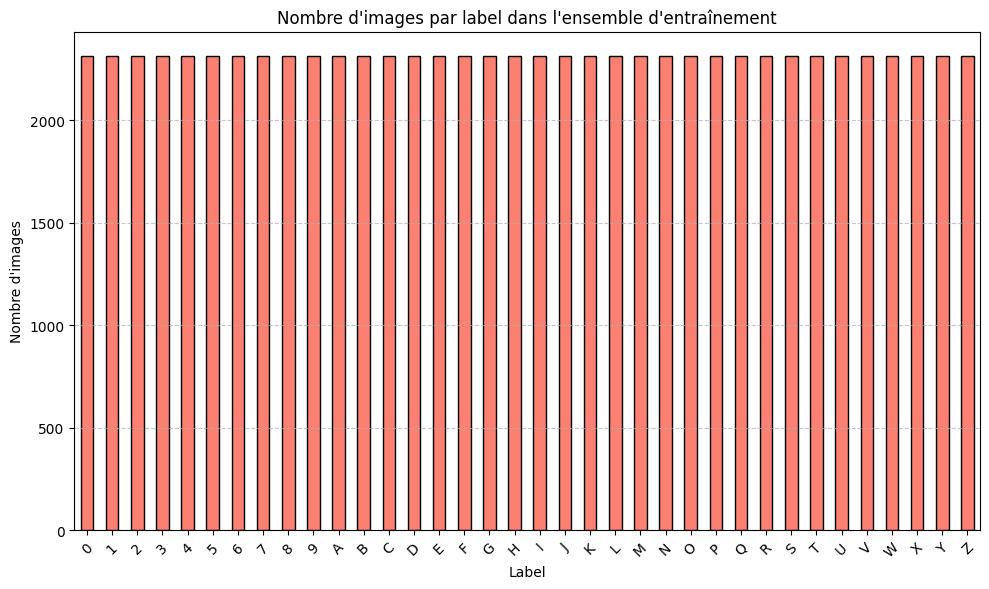

In [ ]:
# --- Visualisation du nombre de labels dans y_train ---
print("\nNombre d'images par label dans l'ensemble d'entra√Ænement (y_train) :")

# Compter la distribution des labels dans y_train
train_label_counts = Counter(y_train)


# Convertir en pandas Series pour le graphique
train_label_series = pd.Series(train_label_counts)

# Sort the series by index (label) for consistent plotting
train_label_series = train_label_series.sort_index()

# üìà Graphe en barres
plt.figure(figsize=(10, 6))
train_label_series.plot(kind='bar', color='salmon', edgecolor='black') # Utiliser une couleur diff√©rente
plt.title("Nombre d'images par label dans l'ensemble d'entra√Ænement")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## --- √âtape 1 : Standardisation des donn√©es ---

In [ ]:
# On met √† l'√©chelle les valeurs des pixels entre 0 et 1 pour faciliter l'entra√Ænement du mod√®le
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(" Donn√©es standardis√©es.")

 Donn√©es standardis√©es.



## --- √âtape 2 : Pr√©paration des donn√©es pour le CNN ---

In [ ]:
# Reshape des donn√©es pour correspondre √† l'entr√©e du CNN : (nombre d'exemples, hauteur, largeur, canaux)
# Ici, images en niveaux de gris, donc canaux = 1
img_height, img_width = TARGET_SIZE
X_train = X_train.reshape(-1, img_height, img_width, 1)
X_test = X_test.reshape(-1, img_height, img_width, 1)

print(f" Donn√©es reshaped pour CNN. Forme de X_train : {X_train.shape}, X_test : {X_test.shape}")

 Donn√©es reshaped pour CNN. Forme de X_train : (83404, 32, 32, 1), X_test : (20852, 32, 32, 1)


##Explication de l'encodage des labels en one-hot vectors

Dans une t√¢che de classification multi-classes, les labels (√©tiquettes) sont souvent des cat√©gories sous forme de cha√Ænes de caract√®res (par exemple : 'A', 'B', 'C', ou '0', '1', '2', etc.).

## Pourquoi encoder les labels ?

- Les mod√®les de deep learning travaillent mieux avec des valeurs num√©riques.
- Il faut convertir ces labels textuels en une repr√©sentation num√©rique compr√©hensible par le mod√®le.

## √âtapes de l'encodage utilis√© ici :

1. **LabelEncoder()**  
   - Transforme chaque label texte en un entier unique.  
   - Exemple : ['A', 'B', 'C', 'A'] ‚Üí [0, 1, 2, 0]

2. **to_categorical()**  
   - Convertit ces entiers en vecteurs "one-hot", c‚Äôest-√†-dire des vecteurs o√π la position correspondant √† la classe est 1, et les autres positions sont 0.  
   - Exemple avec 3 classes :  
     - 0 ‚Üí [1, 0, 0]  
     - 1 ‚Üí [0, 1, 0]  
     - 2 ‚Üí [0, 0, 1]

## Avantages du one-hot encoding :

- Permet au mod√®le de traiter chaque classe comme une cat√©gorie distincte.
- Utilis√© dans la couche de sortie avec activation softmax, qui pr√©dit une probabilit√© pour chaque classe.

---

### R√©sum√©

Le label encoder convertit les classes en entiers, puis la fonction `to_categorical` transforme ces entiers en vecteurs one-hot adapt√©s √† la classification multi-classes dans les r√©seaux de neurones.


In [ ]:
# Encodage des labels en one-hot vectors pour la classification multi-classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

print(f" Labels encod√©s en one-hot. Forme y_train_one_hot : {y_train_one_hot.shape}, y_test_one_hot : {y_test_one_hot.shape}")

 Labels encod√©s en one-hot. Forme y_train_one_hot : (83404, 36), y_test_one_hot : (20852, 36)


In [ ]:
y_train_encoded

## --- √âtape 3 : Construction du mod√®le CNN avec transfert d'apprentissage (MobileNetV2) ---

**Explication : MobileNetV2 et les images en niveaux de gris**

MobileNetV2 est un mod√®le de **r√©seau de neurones convolutifs (CNN)** pr√©-entra√Æn√© sur le jeu de donn√©es ImageNet, qui contient des images en couleur (RGB) avec **3 canaux** (rouge, vert, bleu).

**Relation entre CNN et MobileNetV2**

- **CNN (Convolutional Neural Network)** est une architecture sp√©cialis√©e pour traiter des images en capturant automatiquement les caract√©ristiques visuelles (bords, textures, formes, etc.) via des filtres convolutifs.
- MobileNetV2 est un **type sp√©cifique de CNN optimis√©** pour √™tre l√©ger et efficace, notamment sur des appareils mobiles. Il utilise des blocs convolutifs am√©lior√©s (bottleneck, depthwise separable convolutions) pour r√©duire la complexit√© tout en conservant de bonnes performances.

**Pourquoi convertir les images grayscale en 3 canaux ?**

- Les images en niveaux de gris ont **un seul canal** (intensit√© lumineuse).
- MobileNetV2, comme la plupart des CNN pr√©-entra√Æn√©s sur ImageNet, attend une entr√©e avec **3 canaux** car il a appris √† extraire des caract√©ristiques en exploitant les diff√©rences entre les canaux couleur.
- Pour utiliser MobileNetV2 avec des images grayscale, on **duplique** simplement la m√™me image sur les 3 canaux. Cela permet de cr√©er une image "factice" en 3 canaux, compatible avec le mod√®le, sans perdre l‚Äôinformation initiale.
  
Cette adaptation permet de profiter des puissantes caract√©ristiques apprises par MobileNetV2 m√™me sur des images en niveaux de gris.

---

En r√©sum√©, MobileNetV2 est un CNN efficace con√ßu pour traiter des images couleur (3 canaux). Pour utiliser ce mod√®le avec des images grayscale, on adapte les donn√©es en dupliquant le canal unique pour correspondre √† l'entr√©e attendue, ce qui facilite le transfert d'apprentissage et am√©liore la performance sur votre t√¢che.


In [ ]:
# MobileNetV2 attend une entr√©e avec 3 canaux (RGB), alors on convertit les images grayscale en 3 canaux en dupliquant
X_train_3_channels = np.repeat(X_train, 3, axis=-1)
X_test_3_channels = np.repeat(X_test, 3, axis=-1)

# Charger MobileNetV2 pr√©-entra√Æn√©, sans la t√™te de classification (include_top=False)
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Geler les couches de base pour ne pas entra√Æner MobileNetV2 enti√®rement
base_model.trainable = False

# Construction du mod√®le complet avec ajout de couches de pooling et dense pour classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # R√©duit la sortie de MobileNet en un vecteur moyen global
    Dense(128, activation='relu'),  # Couche fully connected avec activation ReLU
    Dropout(0.5),  # R√©gularisation pour √©viter le surapprentissage
    Dense(len(label_encoder.classes_), activation='softmax')  # Couche de sortie avec activation softmax pour classification multi-classes
])

print(" Mod√®le CNN construit avec MobileNetV2.")


<ipython-input-27-661dcf4e0ec4>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


9406464/9406464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step
 Mod√®le CNN construit avec MobileNetV2.


# 2) Entra√Ænement d'un mod√®le CNN avec MobileNetV2 et Keras Tuner

Les √©tapes de l'entra√Ænement d'un mod√®le de classification d'images en utilisant un mod√®le pr√©-entra√Æn√© **MobileNetV2** et une recherche d'hyperparam√®tres via **Keras Tuner**:



1. **Recherche des meilleurs hyperparam√®tres** :
   - Taux d'apprentissage (`learning_rate`)
   - Nombre de neurones dans la couche dense (`dense_units`)
   - Taux de Dropout (`dropout_rate`)
   - Entra√Ænement du mod√®le de base (`fine_tune`)

In [ ]:
# --- Mod√®le avec Keras Tuner ---
def build_model(hp):
    base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                             include_top=False, weights='imagenet')
    base_model.trainable = hp.Boolean('fine_tune', default=False)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.7])))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-4, 5e-4, 1e-3])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='mobilenetv2_opt'
)

tuner.search(X_train_3_channels, y_train_one_hot,
             epochs=5,
             batch_size=32,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# --- Extraire les r√©sultats du tuner dans un DataFrame ---
results = tuner.results_summary(num_trials=100)  # Affiche dans la console
# Pour r√©cup√©rer les r√©sultats sous forme de DataFrame :
df = pd.DataFrame([
    {
        'dense_units': trial.hyperparameters.get('dense_units'),
        'dropout_rate': trial.hyperparameters.get('dropout_rate'),
        'lr': trial.hyperparameters.get('lr'),
        'fine_tune': trial.hyperparameters.get('fine_tune'),
        'val_accuracy': trial.score
    }
    for trial in tuner.oracle.get_best_trials(num_trials=100)
    if trial.status == 'COMPLETED'
])


Trial 2 Complete [00h 04m 26s]
val_accuracy: 0.9534800052642822

Best val_accuracy So Far: 0.9534800052642822
Total elapsed time: 00h 06m 32s
Results summary
Results in tuner_dir/mobilenetv2_opt
Showing 100 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
fine_tune: True
dense_units: 256
dropout_rate: 0.5
lr: 0.0005
Score: 0.9534800052642822

Trial 0 summary
Hyperparameters:
fine_tune: False
dense_units: 256
dropout_rate: 0.7
lr: 0.001
Score: 0.5600383877754211


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(" Meilleurs hyperparam√®tres trouv√©s :", best_hyperparameters.values)

<ipython-input-31-fc6dcde9e76e>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


 Meilleurs hyperparam√®tres trouv√©s : {'fine_tune': True, 'dense_units': 256, 'dropout_rate': 0.5, 'lr': 0.0005}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



2. **Construction du mod√®le final** :
   - Base : `MobileNetV2` sans la couche de classification
   - Ajout de : GlobalAveragePooling, Dense, Dropout, et une couche Softmax
   - Compilation avec `Adam` et `categorical_crossentropy`


In [ ]:
# --- R√©cup√©ration des meilleurs hyperparam√®tres ---
best_hps = best_hyperparameters.values
fine_tune = best_hps['fine_tune']         # Faut-il entra√Æner ou non les couches du mod√®le pr√©-entra√Æn√© ?
dense_units = best_hps['dense_units']     # Nombre de neurones dans la couche Dense
dropout_rate = best_hps['dropout_rate']   # Taux de Dropout pour la r√©gularisation
learning_rate = best_hps['lr']            # Taux d'apprentissage

print(f" Entra√Ænement du mod√®le final avec les meilleurs hyperparam√®tres :")
print(f"  fine_tune: {fine_tune}")
print(f"  dense_units: {dense_units}")
print(f"  dropout_rate: {dropout_rate}")
print(f"  learning_rate: {learning_rate}")

# --- Construction du mod√®le final avec les meilleurs hyperparam√®tres ---
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False, weights='imagenet')  # Chargement du mod√®le MobileNetV2 sans la t√™te

# D√©finir si le mod√®le de base est entra√Ænable ou non
base_model.trainable = fine_tune

# Cr√©ation du mod√®le final (s√©quentiel)
final_model = Sequential([
    base_model,                                 # Mod√®le pr√©-entra√Æn√© comme extracteur de caract√©ristiques
    GlobalAveragePooling2D(),                   # R√©duction de dimensions apr√®s les convolutions
    Dense(dense_units, activation='relu'),      # Couche Dense avec ReLU
    Dropout(dropout_rate),                      # Dropout pour √©viter le surapprentissage
    Dense(len(label_encoder.classes_), activation='softmax')  # Couche de sortie (classification multi-classes)
])

# Compilation du mod√®le avec l'optimiseur Adam et le taux d'apprentissage choisi
final_model.compile(optimizer=Adam(learning_rate=learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("Mod√®le final construit et compil√©.")

# --- D√©finition des callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,            # Arr√™t si la performance ne s'am√©liore pas pendant 15 epochs
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'final_best_model.h5',  # Enregistrement du meilleur mod√®le
    save_best_only=True,
    monitor='val_loss'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # R√©duction du taux d'apprentissage si stagnation
    patience=7,
    min_lr=0.0001
)

 Entra√Ænement du mod√®le final avec les meilleurs hyperparam√®tres :
  fine_tune: True
  dense_units: 256
  dropout_rate: 0.5
  learning_rate: 0.0005


<ipython-input-37-2b0571a679ec>:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


Mod√®le final construit et compil√©.


3. **Entra√Ænement du mod√®le final** :
   - Utilisation de callbacks : `EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau`
   - Validation crois√©e (20% des donn√©es pour la validation)

In [ ]:
# --- Entra√Ænement du mod√®le final ---
print("\n Entra√Ænement du mod√®le final...")
history_final = final_model.fit(
    X_train_3_channels, y_train_one_hot,
    epochs=10,              # Nombre d‚Äô√©poques fix√© √† 10 (peut √™tre augment√©)
    batch_size=32,
    validation_split=0.2,   # 20 % des donn√©es utilis√©es pour la validation
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print(" Entra√Ænement du mod√®le final termin√©.")


‚è≥ Entra√Ænement du mod√®le final...
Epoch 1/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step - accuracy: 0.5774 - loss: 1.6240

2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 95s 25ms/step - accuracy: 0.5775 - loss: 1.6236 - val_accuracy: 0.8534 - val_loss: 0.5066 - learning_rate: 5.0000e-04
Epoch 2/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.8922 - loss: 0.3953

2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 15ms/step - accuracy: 0.8922 - loss: 0.3952 - val_accuracy: 0.9344 - val_loss: 0.2440 - learning_rate: 5.0000e-04
Epoch 3/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 30s 14ms/step - accuracy: 0.9163 - loss: 0.3124 - val_accuracy: 0.9405 - val_loss: 0.3178 - learning_rate: 5.0000e-04
Epoch 4/10
2083/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.9367 - loss: 0.2342

2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43s 15ms/step - accuracy: 0.9367 - loss: 0.2341 - val_accuracy: 0.9478 - val_loss: 0.2081 - learning_rate: 5.0000e-04
Epoch 5/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - accuracy: 0.9438 - loss: 0.2156

2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 20ms/step - accuracy: 0.9438 - loss: 0.2156 - val_accuracy: 0.9546 - val_loss: 0.1920 - learning_rate: 5.0000e-04
Epoch 6/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 32s 15ms/step - accuracy: 0.9526 - loss: 0.1775 - val_accuracy: 0.9345 - val_loss: 0.2829 - learning_rate: 5.0000e-04
Epoch 7/10
2084/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - accuracy: 0.9537 - loss: 0.1747

2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 16ms/step - accuracy: 0.9537 - loss: 0.1747 - val_accuracy: 0.9689 - val_loss: 0.1264 - learning_rate: 5.0000e-04
Epoch 8/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 14ms/step - accuracy: 0.9591 - loss: 0.1532 - val_accuracy: 0.9567 - val_loss: 0.1855 - learning_rate: 5.0000e-04
Epoch 9/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 15ms/step - accuracy: 0.9589 - loss: 0.1501 - val_accuracy: 0.9609 - val_loss: 0.1510 - learning_rate: 5.0000e-04
Epoch 10/10
2086/2086 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 14ms/step - accuracy: 0.9636 - loss: 0.1316 - val_accuracy: 0.9606 - val_loss: 0.1504 - learning_rate: 5.0000e-04
‚úÖ Entra√Ænement du mod√®le final termin√©.


#3)√âvaluation du mod√®le final

4. **Sauvegarde et √©valuation** :
   - Le meilleur mod√®le est sauvegard√© automatiquement
   - Possibilit√© d'√©valuer sur les donn√©es de test par la suite

---

In [ ]:
# --- √âvaluation du mod√®le final ---
print("\n √âvaluation du mod√®le final...")
loss_final, accuracy_final = final_model.evaluate(X_test_3_channels, y_test_one_hot)
print(f" Perte du Test final : {loss_final:.4f}")
print(f" Pr√©cision du Test final : {accuracy_final:.4f}")


 √âvaluation du mod√®le final...
652/652 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 9ms/step - accuracy: 0.9673 - loss: 0.1168
 Perte du Test final : 0.1291
 Pr√©cision du Test final : 0.9665


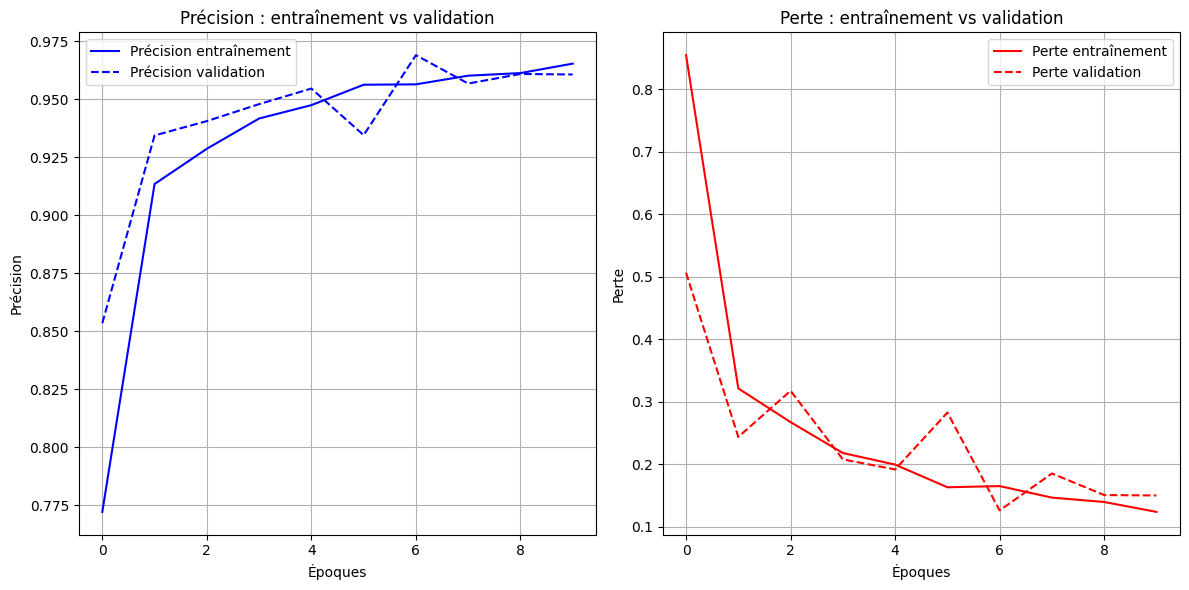

In [ ]:
# R√©cup√©ration des pr√©cisions d'entra√Ænement et de validation
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']

# R√©cup√©ration des pertes d'entra√Ænement et de validation
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

# Cr√©ation de la plage des √©poques (x-axis)
epochs = range(len(acc))

# --- Affichage des courbes d'entra√Ænement et de validation ---
plt.figure(figsize=(12, 6))

# Sous-graphique 1 : Pr√©cision (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Pr√©cision entra√Ænement')       # Ligne bleue continue
plt.plot(epochs, val_acc, 'b--', label='Pr√©cision validation')     # Ligne bleue pointill√©e
plt.title('Pr√©cision : entra√Ænement vs validation')
plt.xlabel('√âpoques')
plt.ylabel('Pr√©cision')
plt.legend()
plt.grid(True)

# Sous-graphique 2 : Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Perte entra√Ænement')           # Ligne rouge continue
plt.plot(epochs, val_loss, 'r--', label='Perte validation')        # Ligne rouge pointill√©e
plt.title('Perte : entra√Ænement vs validation')
plt.xlabel('√âpoques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Ajustement automatique de la mise en page
plt.tight_layout()
plt.show()


**Analyse R√©sum√©e des Courbes d‚ÄôEntra√Ænement**

Les courbes de pr√©cision et de perte montrent que le mod√®le OCR apprend efficacement sans tomber dans l‚Äô**overfitting**.

-  **Pr√©cision** : Les courbes d‚Äôentra√Ænement et de validation sont proches et augmentent r√©guli√®rement, ce qui indique un bon apprentissage et une bonne g√©n√©ralisation.
-  **Perte** : Les pertes diminuent pour les deux ensembles avec une l√©g√®re instabilit√© c√¥t√© validation, due aux donn√©es bruit√©es. Elles restent cependant proches.

Le mod√®le est **robuste** et **g√©n√©ralise bien**. L‚Äô**augmentation de donn√©es** a permis d‚Äôam√©liorer sa r√©sistance aux d√©fauts des images √† faible r√©solution, sans nuire aux performances.


In [ ]:
from sklearn.metrics import confusion_matrix

# --- G√©n√©rer les pr√©dictions sur l'ensemble de test ---
print("\n G√©n√©ration des pr√©dictions sur l'ensemble de test...")
y_pred_one_hot = final_model.predict(X_test_3_channels)

# Conversion des pr√©dictions et des vraies √©tiquettes de one-hot vers indices de classes
y_pred_classes = np.argmax(y_pred_one_hot, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

print(" Pr√©dictions g√©n√©r√©es.")

# --- Calcul de la matrice de confusion ---
# On suppose que le label_encoder est d√©j√† entra√Æn√© sur l'ensemble des √©tiquettes
class_names = label_encoder.classes_

cm = confusion_matrix(y_true_classes, y_pred_classes)



 G√©n√©ration des pr√©dictions sur l'ensemble de test...
652/652 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 6ms/step
 Pr√©dictions g√©n√©r√©es.


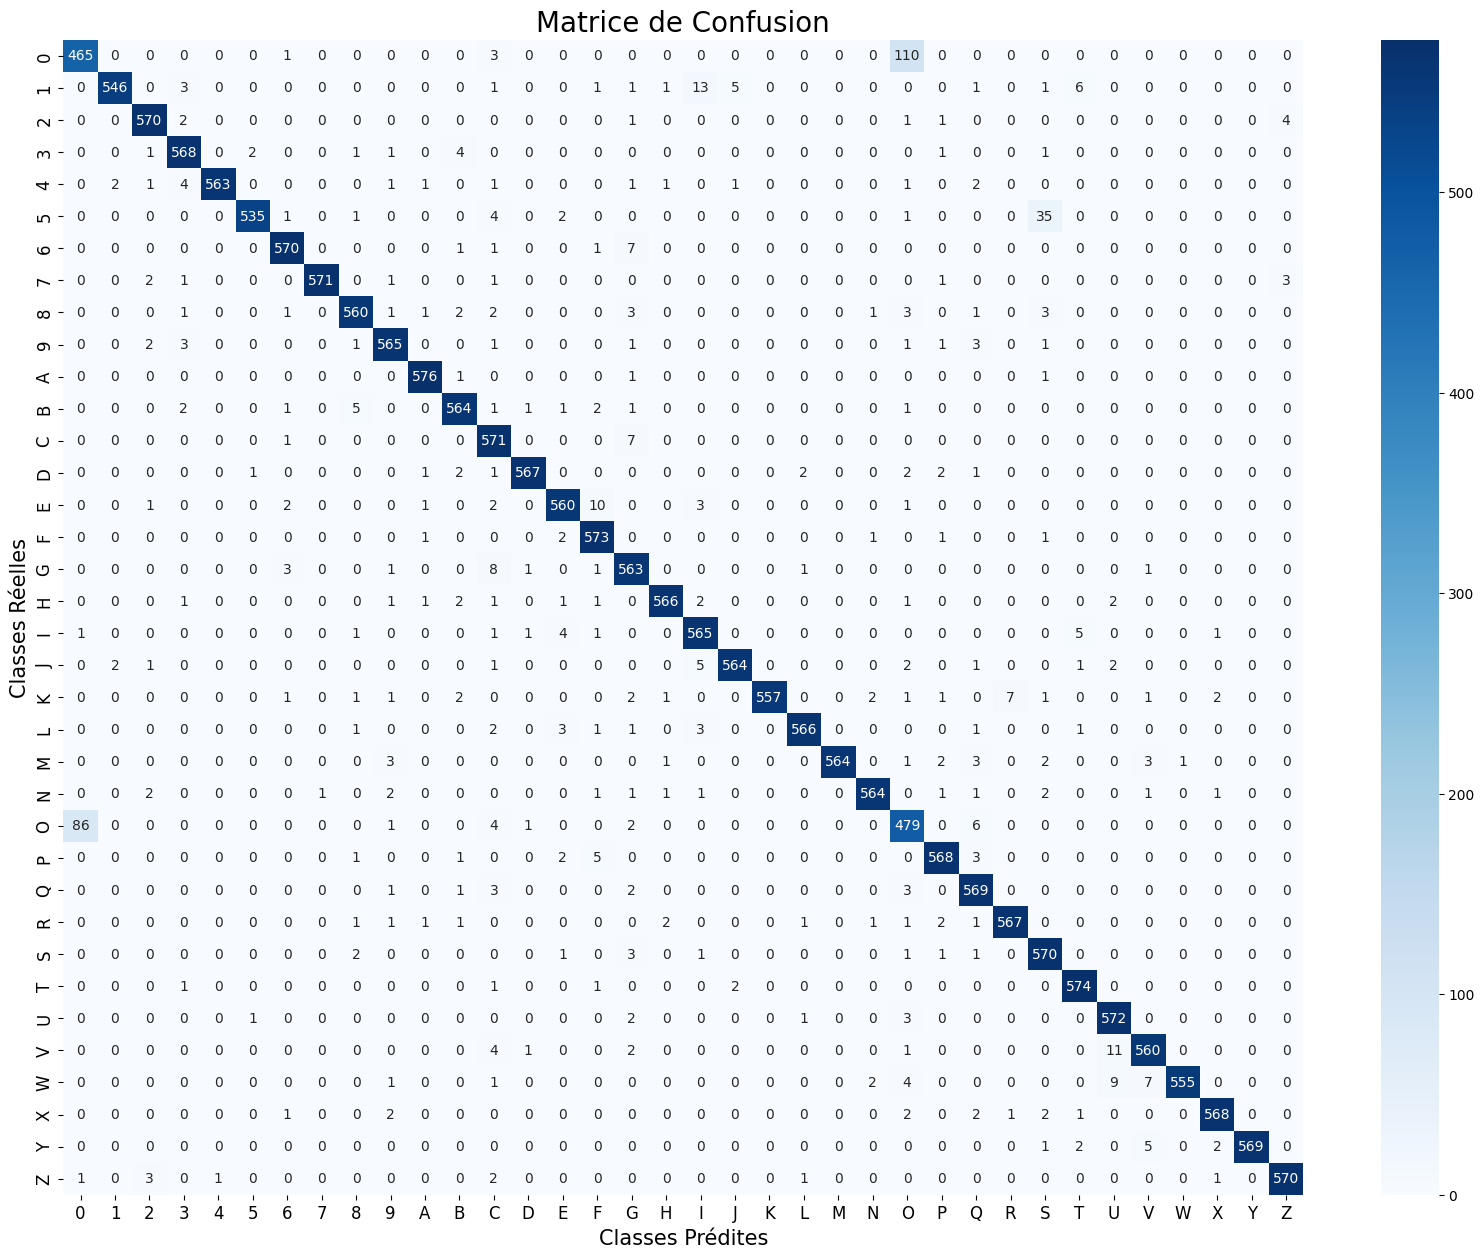


 Matrice de confusion affich√©e.


In [ ]:
# --- Affichage de la matrice de confusion ---
# Cr√©ation d'une figure plus grande pour am√©liorer la lisibilit√© du graphique
plt.figure(figsize=(20, 15))  # Largeur : 20, Hauteur : 15

# Affichage de la matrice avec des couleurs et les annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Personnalisation du graphique : titre et labels des axes
plt.title('Matrice de Confusion', fontsize=20)           # Titre en plus grand
plt.xlabel('Classes Pr√©dites', fontsize=15)              # Axe des X : classes pr√©dites
plt.ylabel('Classes R√©elles', fontsize=15)               # Axe des Y : classes r√©elles
plt.xticks(fontsize=12)                                  # Taille de police pour les √©tiquettes X
plt.yticks(fontsize=12)                                  # Taille de police pour les √©tiquettes Y

# Affichage final du graphique
plt.show()

print("\n Matrice de confusion affich√©e.")

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# --- G√©n√©ration du rapport de classification de sklearn ---
report = classification_report(y_true_classes, y_pred_classes,
                               target_names=class_names, output_dict=True)

# --- Calcul manuel des m√©triques suppl√©mentaires (sp√©cificit√©, erreur) ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
metrics = []

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensibilit√©
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    error = (FP + FN) / (TP + FN + FP + TN)

    metrics.append({
        "Classe": class_name,
        "Pr√©cision": round(precision, 3),
        "Rappel (Recall)": round(recall, 3),
        "Sp√©cificit√©": round(specificity, 3),
        "F1-score": round(f1, 3),
        "Taux d'erreur": round(error, 3)
    })

# --- Cr√©ation du tableau final ---
df_metrics = pd.DataFrame(metrics)

# --- Affichage du tableau ---
print("üìã Tableau des m√©triques par classe :\n")
display(df_metrics)

# --- Accuracy globale ---
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\n Exactitude (accuracy) globale : {round(accuracy, 4)}")


üìã Tableau des m√©triques par classe :



Classe  Pr√©cision  Rappel (Recall)  Sp√©cificit√©  F1-score  Taux d'erreur
0       0      0.841            0.803        0.996     0.822          0.010
1       1      0.993            0.943        1.000     0.967          0.002
2       2      0.978            0.984        0.999     0.981          0.001
3       3      0.969            0.981        0.999     0.975          0.001
4       4      0.998            0.972        1.000     0.985          0.001
5       5      0.993            0.924        1.000     0.957          0.002
6       6      0.979            0.983        0.999     0.981          0.001
7       7      0.998            0.984        1.000     0.991          0.000
8       8      0.974            0.967        0.999     0.971          0.002
9       9      0.969            0.976        0.999     0.972          0.002
10      A      0.988            0.995        1.000     0.991          0.000
11      B      0.971            0.974        0.999     0.972          0.002
12      C      0.925            0.986        0.998     0.955          0.003
13      D      0.991            0.979        1.000     0.985          0.001
14      E      0.972            0.966        0.999     0.969          0.002
15      F      0.958            0.990        0.999     0.974          0.001
16      G      0.937            0.972        0.998     0.954          0.003
17      H      0.988            0.978        1.000     0.983          0.001
18      I      0.953            0.974        0.999     0.963          0.002
19      J      0.986            0.974        1.000     0.980          0.001
20      K      1.000            0.960        1.000     0.980          0.001
21      L      0.990            0.978        1.000     0.983          0.001
22      M      1.000            0.972        1.000     0.986          0.001
23      N      0.988            0.974        1.000     0.981          0.001
24      O      0.773            0.827        0.993     0.799          0.012
25      P      0.976            0.979        0.999     0.978          0.001
26      Q      0.955            0.983        0.999     0.969          0.002
27      R      0.986            0.979        1.000     0.983          0.001
28      S      0.918            0.983        0.997     0.949          0.003
29      T      0.973            0.991        0.999     0.982          0.001
30      U      0.960            0.988        0.999     0.974          0.001
31      V      0.969            0.967        0.999     0.968          0.002
32      W      0.998            0.959        1.000     0.978          0.001
33      X      0.988            0.981        1.000     0.984          0.001
34      Y      1.000            0.983        1.000     0.991          0.000
35      Z      0.988            0.984        1.000     0.986          0.001


 Exactitude (accuracy) globale : 0.9665


In [ ]:
def extract(image, model, mapping_inverse):
    chars = []
    image_cpy = image.copy()

    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)

    for word in words:
        x, y, w, h = word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)

        for char in char_parts:
            x, y, w, h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)
            resized = cv2.resize(ch, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[3:3+22, 3:3+16, 0] = gray.copy()

            rgb_img = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            rgb_img = rgb_img.astype(np.int32)

            pred = model.predict(np.array([rgb_img]), verbose=0)
            predicted_char = mapping_inverse[np.argmax(pred)]
            chars.append(predicted_char)

        chars.append(' ')  # espace entre mots

    return ''.join(chars[:-1])  # retirer le dernier espace


In [ ]:
# --- Pr√©dictions sur l'ensemble de test ---
print("\n* G√©n√©ration des pr√©dictions sur l'ensemble de test...")
y_pred_one_hot = final_model.predict(X_test_3_channels)

# Conversion des pr√©dictions et labels one-hot en indices de classes
y_pred_indices = np.argmax(y_pred_one_hot, axis=1)
y_true_indices = np.argmax(y_test_one_hot, axis=1)

# R√©cup√©ration des labels originaux via le label encoder
y_pred_labels = label_encoder.classes_[y_pred_indices]
y_true_labels = label_encoder.classes_[y_true_indices]

print("Pr√©dictions converties en labels.")

# Cr√©ation du DataFrame avec labels vrais, pr√©dits et indicateur de bonne classification
results_df = pd.DataFrame({
    'Vrai_Label': y_true_labels,
    'Pr√©dit_Label': y_pred_labels,
    'Correct': y_true_labels == y_pred_labels
})

print("\nAper√ßu des r√©sultats :")
results_df.head()


* G√©n√©ration des pr√©dictions sur l'ensemble de test...
652/652 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 6ms/step
Pr√©dictions converties en labels.

Aper√ßu des r√©sultats :


Vrai_Label Pr√©dit_Label  Correct
0          L            L     True
1          B            B     True
2          G            G     True
3          0            0     True
4          F            E    False

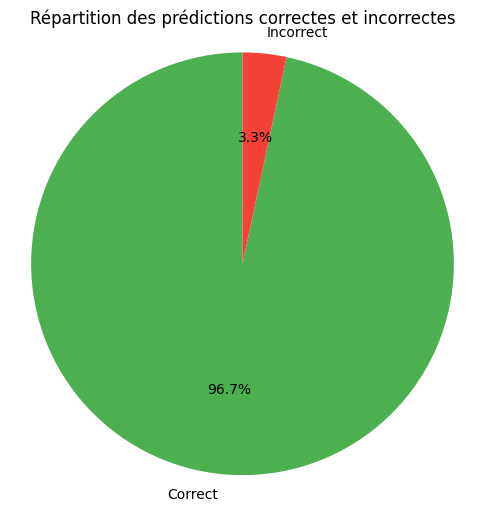

In [ ]:
# Comptage des bonnes et mauvaises pr√©dictions
counts = results_df['Correct'].value_counts()
labels = ['Correct' if x else 'Incorrect' for x in counts.index]
sizes = counts.values

# Trac√© du camembert
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#F44336'], startangle=90)
plt.title("R√©partition des pr√©dictions correctes et incorrectes")
plt.axis('equal')  # Assure que le graphique est circulaire
plt.show()


**Analyse de la r√©partition des pr√©dictions**

Le diagramme circulaire ci-dessus illustre la performance globale du mod√®le en termes de pr√©dictions correctes et incorrectes :

-  **Pr√©dictions correctes** : **96.7‚ÄØ%**
-  **Pr√©dictions incorrectes** : **3.3‚ÄØ%**

Cela indique que le mod√®le est globalement tr√®s pr√©cis, avec une excellente capacit√© de g√©n√©ralisation.  
Le faible taux d‚Äôerreur (**3.3‚ÄØ%**) confirme l‚Äôefficacit√© du mod√®le sur les donn√©es de test.


#4)Sauvegarde du mod√®le entra√Æn√© & G√©n√©ration des pr√©dictions

In [ ]:
# --- Sauvegarde du mod√®le entra√Æn√© ---

# D√©finition du chemin o√π enregistrer le mod√®le
model_save_path = 'final_trained_model.h5'

print(f" Sauvegarde du mod√®le entra√Æn√© vers {model_save_path}...")

# Sauvegarde compl√®te du mod√®le : architecture, poids et √©tat de l'optimiseur
final_model.save(model_save_path)

print(" Mod√®le sauvegard√© avec succ√®s.")

# V√©rification optionnelle que le fichier a bien √©t√© cr√©√©
import os
if os.path.exists(model_save_path):
    print(f"Le fichier mod√®le '{model_save_path}' a bien √©t√© cr√©√©.")
else:
    print(f"Erreur lors de la sauvegarde du fichier mod√®le '{model_save_path}'.")

 Sauvegarde du mod√®le entra√Æn√© vers final_trained_model.h5...
 Mod√®le sauvegard√© avec succ√®s.
Le fichier mod√®le 'final_trained_model.h5' a bien √©t√© cr√©√©.


In [ ]:
import os

# Define the path for the new directory
new_directory_path = 'data_rgb'

# Create the directory
try:
    os.makedirs(new_directory_path)
    print(f"‚úÖ Dossier '{new_directory_path}' cr√©√© avec succ√®s.")
except FileExistsError:
    print(f"Le dossier '{new_directory_path}' existe d√©j√†.")
except Exception as e:
    print(f"Une erreur s'est produite lors de la cr√©ation du dossier : {e}")

Le dossier 'data_rgb' existe d√©j√†.


In [ ]:
import os

# D√©finir le chemin du dossier
directory_path = '/content/data_test'

# Cr√©er le dossier s'il n'existe pas d√©j√†
os.makedirs(directory_path, exist_ok=True)

print(f"Le dossier '{directory_path}' a √©t√© cr√©√© avec succ√®s (ou existe d√©j√†).")


Le dossier '/content/data_test' a √©t√© cr√©√© avec succ√®s (ou existe d√©j√†).


Dossier '/content/data_test' trouv√©.
6 fichiers image trouv√©s dans le dossier.

G√©n√©ration des pr√©dictions pour chaque image...
Image: images.jpeg, Pr√©diction: O


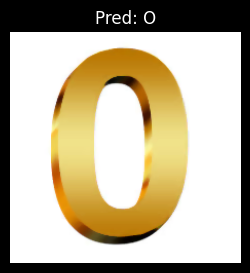

Image: imageE.png, Pr√©diction: E


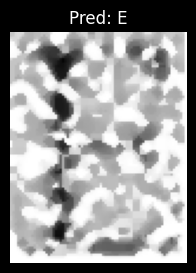

Image: 61Gnse56wAL._AC_UF1000,1000_QL80_.jpg, Pr√©diction: B


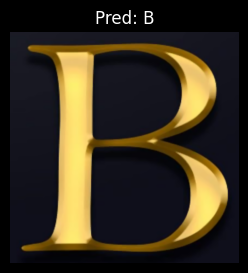

Image: copy-of-chiffre-0.jpg, Pr√©diction: 1


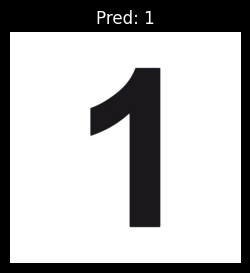

Image: E.png, Pr√©diction: E


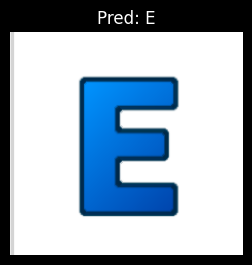

Image: image1.jpeg, Pr√©diction: D


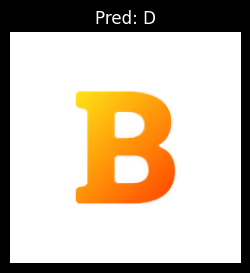


‚úÖ Pr√©dictions termin√©es pour toutes les images.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Param√®tres
test_directory_path = "/content/data_test"
TARGET_SIZE = (32, 32)  # Nouvelle taille
ZOOM_MARGIN = 20  # Marge autour de l'objet d√©tect√©

# V√©rifie l'existence du dossier
if not os.path.isdir(test_directory_path):
    print(f"Erreur: Le dossier '{test_directory_path}' n'existe pas.")
else:
    print(f"Dossier '{test_directory_path}' trouv√©.")

    image_files = [f for f in os.listdir(test_directory_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Aucun fichier image trouv√© dans le dossier '{test_directory_path}'.")
    else:
        print(f"{len(image_files)} fichiers image trouv√©s dans le dossier.")
        print("\nG√©n√©ration des pr√©dictions pour chaque image...")

        for filename in image_files:
            image_path = os.path.join(test_directory_path, filename)
            image_to_test = cv2.imread(image_path, cv2.IMREAD_COLOR)

            if image_to_test is None:
                print(f"Erreur: Impossible de charger l'image '{filename}'. Skipping.")
                continue

            # Appliquer un filtre m√©dian (r√©duction du bruit)
            image_filtered = cv2.medianBlur(image_to_test, 5)

            # Convertir en niveaux de gris
            img_gray = cv2.cvtColor(image_filtered, cv2.COLOR_BGR2GRAY)

            # --- Zoom sur l'objet (bounding box de contours) ---
            thresh = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY)[1]
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Bo√Æte englobante la plus grande
                x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                x1 = max(x - ZOOM_MARGIN, 0)
                y1 = max(y - ZOOM_MARGIN, 0)
                x2 = min(x + w + ZOOM_MARGIN, image_to_test.shape[1])
                y2 = min(y + h + ZOOM_MARGIN, image_to_test.shape[0])
                image_zoomed = image_filtered[y1:y2, x1:x2]
            else:
                image_zoomed = image_filtered  # Aucun contour trouv√©

            # Redimensionner √† 32x32
            img_resized = cv2.resize(cv2.cvtColor(image_zoomed, cv2.COLOR_BGR2GRAY), TARGET_SIZE)

            # Normaliser et pr√©parer l'entr√©e du mod√®le
            img_normalized = img_resized.astype('float32') / 255.0
            img_reshaped = img_normalized.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
            img_input_model = np.repeat(img_reshaped, 3, axis=-1)

            # Pr√©diction
            prediction_probabilities = final_model.predict(img_input_model, verbose=0)
            predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
            predicted_label = label_encoder.classes_[predicted_class_index]

            # Affichage
            print(f"Image: {filename}, Pr√©diction: {predicted_label}")
            plt.figure(figsize=(3, 3))
            plt.imshow(cv2.cvtColor(image_zoomed, cv2.COLOR_BGR2RGB))
            plt.title(f"Pred: {predicted_label}")
            plt.axis('off')
            plt.show()

        print("\n‚úÖ Pr√©dictions termin√©es pour toutes les images.")


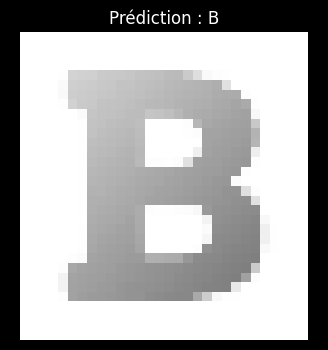

In [ ]:
    # 8. Redimensionnement final
    image_final = cv2.resize(image_gray, TARGET_SIZE)

    # 9. Normalisation et pr√©paration pour mod√®le
    img_normalized = image_final.astype('float32') / 255.0
    img_reshaped = img_normalized.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
    img_input_model = np.repeat(img_reshaped, 3, axis=-1)

    # Pr√©diction
    prediction_probabilities = final_model.predict(img_input_model, verbose=0)
    predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Affichage
    plt.figure(figsize=(4, 4))
    plt.imshow(image_final, cmap='gray')
    plt.title(f"Pr√©diction : {predicted_label}")
    plt.axis('off')
    plt.show()
